## Deep Learning Bug Classification

Link to blog post: https://delashu.github.io/bigdat/dl.html

In [1]:
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization

In [2]:
#create a list of training files with full file paths
training_files = []
#create a list of the labels of these training files
training_labels = []
for file_path in pathlib.Path("insects/train/beetles/").glob('**/*'):
    training_files.append(str(file_path.absolute()))
    training_labels.append("beetles")
for file_path in pathlib.Path("insects/train/cockroach/").glob('**/*'):
    training_files.append(str(file_path.absolute()))
    training_labels.append("cockroach")
for file_path in pathlib.Path("insects/train/dragonflies/").glob('**/*'):
    training_files.append(str(file_path.absolute()))
    training_labels.append("dragonflies")  

In [3]:
#create a list of test files with full file paths    
test_files = []
#create a list of the labels of the test files
test_labels = []
for file_path in pathlib.Path("insects/test/beetles/").glob('**/*'):
    test_files.append(str(file_path.absolute()))
    test_labels.append("beetles")
for file_path in pathlib.Path("insects/test/cockroach/").glob('**/*'):
    test_files.append(str(file_path.absolute()))
    test_labels.append("cockroach")
for file_path in pathlib.Path("insects/test/dragonflies/").glob('**/*'):
    test_files.append(str(file_path.absolute()))
    test_labels.append("dragonflies")

In [4]:
#create training dataframe of files and labels
train_df = pd.DataFrame({
    'file':training_files,
    'label':training_labels
})
#create test dataframe of files and labels
test_df = pd.DataFrame({
    'file':test_files,
    'label':test_labels
})
#change labels via one-hot encoding
train_df["label"] = train_df["label"].replace({0:'beetle',1:'cockroach',2:'dragonflies'})
test_df["label"] = test_df["label"].replace({0:'beetle',1:'cockroach',2:'dragonflies'})
num_classes = len(test_df["label"].unique())

In [5]:
#Define the image properties
width = 128
height = 128
img_sz = (width,height)
channels = 3
mybatch = 8

In [6]:
#data generation for the training images
train_idg = ImageDataGenerator(rotation_range = 15,
                                rescale = 1./255,
                                shear_range = 0.1,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                                width_shift_range = 0.1,
                                height_shift_range = 0.1
                                )

train_flow = train_idg.flow_from_dataframe(train_df,
                                                 x_col = 'file',
                                                 y_col = 'label',
                                                 target_size = img_sz,
                                                 class_mode = 'categorical',
                                                 batch_size = mybatch)

Found 1019 validated image filenames belonging to 3 classes.


In [7]:
#Create NN Model:
NNmodel=Sequential()
NNmodel.add(Conv2D(32,(3,3),activation='relu',input_shape=(width, height, channels)))
NNmodel.add(BatchNormalization())
NNmodel.add(MaxPooling2D(pool_size=(2,2)))
NNmodel.add(Dropout(0.15))
NNmodel.add(Conv2D(64,(3,3),activation='relu'))
NNmodel.add(BatchNormalization())
NNmodel.add(MaxPooling2D(pool_size=(2,2)))
NNmodel.add(Dropout(0.25))
NNmodel.add(Conv2D(128,(3,3),activation='relu'))
NNmodel.add(BatchNormalization())
NNmodel.add(MaxPooling2D(pool_size=(2,2)))
NNmodel.add(Dropout(0.05))
NNmodel.add(Flatten())
NNmodel.add(Dense(512,activation='relu'))
NNmodel.add(BatchNormalization())
NNmodel.add(Dropout(0.5))
NNmodel.add(Dense(num_classes,activation='softmax'))
NNmodel.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

In [8]:
#define the callbacks and learning rate:
earlystop = EarlyStopping(patience = 10)
#give the early stop patience of 10
learning_rate_reduction = ReduceLROnPlateau(patience = 2,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.00001)
#set the learning rate reduction parameters of 2,1,0.5, 0.00001
callbacks = [earlystop, learning_rate_reduction]

In [9]:
#we've created a training set. From the training set, subset 15% as validation
#set the seed as 1125
training_df, validation_df = train_test_split(train_df, test_size=0.15, random_state = 1125)
training_df = training_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [10]:
#prepare validation set
validation_idg = ImageDataGenerator(rescale=1./255)
validation_flow = validation_idg.flow_from_dataframe(
    validation_df,x_col='file',y_col='label',
    target_size=img_sz, class_mode='categorical',
    batch_size=mybatch)

Found 153 validated image filenames belonging to 3 classes.


In [11]:
#prepare test set
test_idg = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

test_flow = test_idg.flow_from_dataframe(test_df,
                                                  x_col='file',y_col='label',
                                                  target_size=img_sz, class_mode='categorical',
                                                  batch_size=mybatch)

Found 180 validated image filenames belonging to 3 classes.


In [18]:
#train the model with 10 epochs:
from keras.callbacks import EarlyStopping, ModelCheckpoint
epochs=10
total_validate = validation_df.shape[0]
total_train = train_df.shape[0]
history = NNmodel.fit(
    train_flow, 
    epochs=epochs,
    validation_data=validation_flow,
    validation_steps=total_validate//mybatch,
    steps_per_epoch=total_train//mybatch,
    callbacks=callbacks
)

Using TensorFlow backend.


Epoch 1/10
127/127 [==============================] - 33s 258ms/step - loss: 0.4164 - accuracy: 0.8467 - val_loss: 0.3995 - val_accuracy: 0.8553
Epoch 2/10
127/127 [==============================] - 49s 385ms/step - loss: 0.4514 - accuracy: 0.8408 - val_loss: 0.2948 - val_accuracy: 0.8816
Epoch 3/10
127/127 [==============================] - 52s 409ms/step - loss: 0.4562 - accuracy: 0.8447 - val_loss: 0.3609 - val_accuracy: 0.8553
Epoch 4/10
127/127 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.8526
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
127/127 [==============================] - 57s 446ms/step - loss: 0.4108 - accuracy: 0.8526 - val_loss: 0.5132 - val_accuracy: 0.8224
Epoch 5/10
127/127 [==============================] - 45s 357ms/step - loss: 0.4111 - accuracy: 0.8487 - val_loss: 0.3209 - val_accuracy: 0.8684
Epoch 6/10
127/127 [==============================] - 28s 218ms/step - loss: 0.3733 - accuracy: 0.8625 - val_l

In [32]:
#print the model summary
NNmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [19]:
#NNmodel.save("mod1_bugclassification.h5")
#save the model for later uses and analysis

In [20]:
from tensorflow.keras.models import load_model

In [22]:
#evaluate training loss and accuracy
train_loss, train_accuracy = NNmodel.evaluate(train_flow)
train_loss, train_accuracy

128/128 [==============================] - 8s 63ms/step - loss: 0.1961 - accuracy: 0.9342


(0.1961207240819931, 0.9342492818832397)

In [23]:
#evaluate test loss and accuracy
test_loss, test_accuracy = NNmodel.evaluate(test_flow)
test_loss, test_accuracy

23/23 [==============================] - 1s 60ms/step - loss: 0.2850 - accuracy: 0.9167


(0.28495872020721436, 0.9166666865348816)

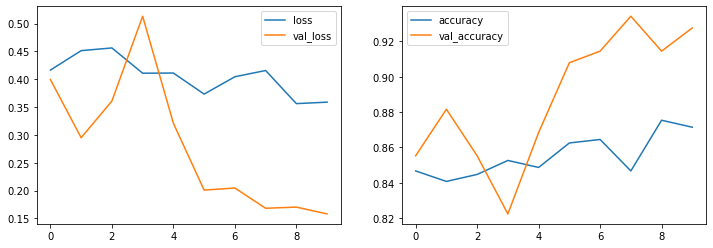

In [24]:
#plot these values
fig, axes = plt.subplots(1,2,figsize=(12, 4))
for ax, measure in zip(axes, ['loss', 'accuracy']):
    ax.plot(history.history[measure], label=measure)
    ax.plot(history.history['val_' + measure], label='val_' + measure)
    ax.legend()
pass


### SHAPLEY VALUES

In [25]:
import shap
import numpy as np

In [26]:
explainer = shap.GradientExplainer(NNmodel, train_flow[0][0])
#we can check the size of train_flow with: train_flow[0][0].shape

In [28]:
sv = explainer.shap_values(test_flow[0][0]);
#use the explainer on some test data

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


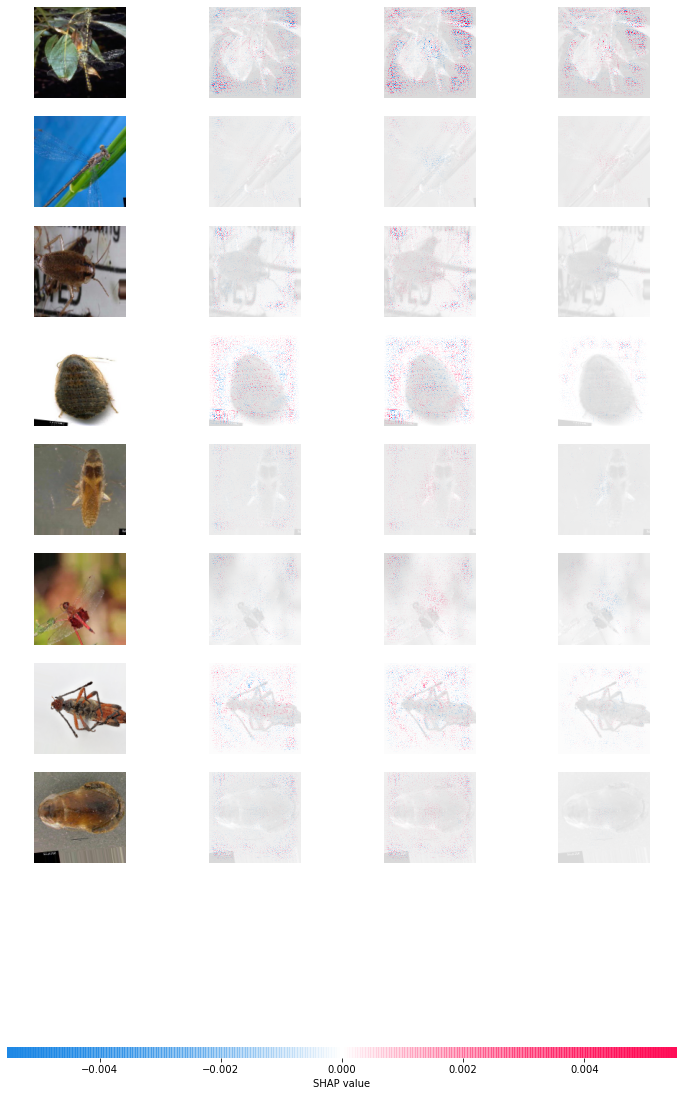

In [29]:
shap.image_plot(sv, test_flow[0][0])

In [37]:
#saving the image (uncomment for save statement): 


# shap_img = shap.image_plot(sv, test_flow[0][0], show = False)  
# from matplotlib import pyplot as plt
# plt.savefig('shap.png') 